## Imports

In [1]:
import cnn_builder as cbuild
import config
import copy
import glob
import importlib
import lipiodol_methods as lm
import niftiutils.helper_fxns as hf
import niftiutils.liver_metrics as lmet
import niftiutils.transforms as tr
import niftiutils.registration as reg
import niftiutils.masks as masks
import numpy as np
import os
from os.path import *
import shutil
import SimpleITK as sitk
import sys
from skimage.morphology import ball
%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
importlib.reload(hf)
C = config.Config()

In [3]:
img_dir = "D:\\Lipiodol\\Images all"
seg_dir = "D:\\Lipiodol\\Images extracted and segmentations"
target_dir = "D:\\Lipiodol\\Data"

### Corrupt data

In [387]:
big_path = r"C:\Users\Clinton\Desktop\bigpath"
header = hf.dcm_load_header(big_path)

In [409]:
dcm_path = [r"C:\Users\Clinton\Desktop\New folder",
        r"C:\Users\Clinton\Desktop\New folder2",
        r"C:\Users\Clinton\Desktop\New folder3",
        r"C:\Users\Clinton\Desktop\New folder4"]

In [407]:
os.makedirs(dcm_path)
os.makedirs(dcm_path2)
os.makedirs(dcm_path3)
os.makedirs(dcm_path4)

In [344]:
wtf_path = r"D:\Lipiodol\Images all\07-AN\#1 9-10-13 MRI baseline\MRI Abdomen W WO Contrast"

In [376]:
acq_t = [82031.93, 82100.41, 82147.77, 82334.49]

In [410]:
for ix,fn in enumerate(glob.glob(join(wtf_path, "*"))):
    h = hf.dcm_load_header(fn)
    for i in range(4):
        if abs(float(h[0].AcquisitionTime) - acq_t[i]) < .02:
            shutil.copy(fn, join(dcm_path[i], basename(fn)))

for fn in glob.glob(join(dcm_path, "*")):
    if int(header[int(fn[-7:-4])-1].TemporalPositionIdentifier) == 2:
        shutil.move(fn, join(dcm_path2, basename(fn)))
    elif int(header[int(fn[-7:-4])-1].TemporalPositionIdentifier) == 3:
        shutil.move(fn, join(dcm_path3, basename(fn)))
    elif int(header[int(fn[-7:-4])-1].TemporalPositionIdentifier) == 4:
        shutil.move(fn, join(dcm_path4, basename(fn)))

In [ ]:
dim = 1
base = float(header[0].SliceLocation)
for x,h in enumerate(header[1:]):
    dz = float(h.SliceLocation) - base
    print(dz)
    base = float(h.SliceLocation)

In [412]:
fn = ["t1-pre.nii", "t1-art.nii", "t1-pv.nii", "t1-equ.nii"]

In [418]:
for i in range(2,3):
    a,dims = hf.dcm_load(dcm_path[i], True, True)
    save_path = join(dirname(dcm_path[i]), "07", fn[i])
    hf.save_nii(a, save_path, dims)

### MRI loading

In [430]:
patient_id = "09"
modality = "MRI-BL"
dcm_paths = [x for x in glob.glob(join(target_dir, patient_id, modality,"*")) if x.find('.')==-1]
for dcm_path in dcm_paths:
    if not exists(splitext(dcm_path)[0] + ".nii"):
        try:
            save_path = splitext(dcm_path)[0] + ".nii"
            img, dims = hf.dcm_load(dcm_path, True, True)
            hf.save_nii(img, save_path, dims)
        except:
            print(dcm_path)

In [130]:
paths = [x for x in glob.glob(join(target_dir, patient_id, modality,"*.nii.gz")) if '20s' in x or 'Ph1-Ax' in x]
if len(paths)==1:
    os.rename(paths[0], join(dirname(paths[0]), "mri_30d_art.nii.gz"))

In [131]:
paths = [x for x in glob.glob(join(target_dir, patient_id, modality,"*.nii.gz")) \
         if ('pre' in x.lower() and 'post' not in x.lower()) or basename(x).startswith('Ax LAVA-XV')]
if len(paths)==1:
    os.rename(paths[0], join(dirname(paths[0]), "mri_30d_pre.nii.gz"))

## Make liver mask

In [145]:
import keras
from config import Config
model = keras.models.load_model(join(Config().model_dir, "mri_liver.hdf5"))

In [ ]:
lm.seg_liver_mri_from_path(mri30d_art_path, mri30d_liver_mask_path, model, mri30d_tumor_mask_path)

## Non-rigid reg

In [464]:
importlib.reload(reg)

<module 'niftiutils.registration' from 'c:\\users\\clinton\\documents\\niftiutils\\niftiutils\\registration.py'>

In [14]:
print(mask_dir)

D:\Lipiodol\Data\12\masks


In [4]:
patient_id = "12"
mask_dir = join(target_dir, patient_id, "masks")
nii_dir = join(target_dir, patient_id, "nii_files")
if not exists(nii_dir):
    os.makedirs(nii_dir)

ct24_path = join(target_dir, patient_id, "nii_files", "ct24.nii.gz")
ct24_tumor_mask_path = glob.glob(join(mask_dir, "tumor*24h*.ids"))[0]

mribl_art_path = join(target_dir, patient_id, "MRI-BL", "mri_bl_art.nii.gz")
mribl_pre_path = join(target_dir, patient_id, "MRI-BL", "mri_bl_pre.nii.gz")
mribl_tumor_mask_path = join(mask_dir, "tumor_BL_MRI")
mribl_liver_mask_path = join(mask_dir, "mri_bl_liver")
mribl_enh_mask_path = join(mask_dir, "enh_bl")
mribl_nec_mask_path = join(mask_dir, "nec_bl")
ct24_bl_enh_mask_path = join(mask_dir, "ct24_bl_enh")
ct24_bl_nec_mask_path = join(mask_dir, "ct24_bl_nec")

mri30d_art_path = join(target_dir, patient_id, "MRI-30d", "mri_30d_art.nii.gz")
mri30d_pre_path = join(target_dir, patient_id, "MRI-30d", "mri_30d_pre.nii.gz")
mri30d_tumor_mask_path = join(mask_dir, "tumor_30dFU_MRI")
mri30d_liver_mask_path = join(mask_dir, "mri_30d_liver")
mri30d_enh_mask_path = join(mask_dir, "enh_30d")
mri30d_nec_mask_path = join(mask_dir, "nec_30d")
ct24_30d_enh_mask_path = join(mask_dir, "ct24_30d_enh")
ct24_30d_nec_mask_path = join(mask_dir, "ct24_30d_nec")

In [133]:
ct_img, ct_dims = hf.dcm_load(join(target_dir, patient_id, "CT24h"), True, True)
hf.save_nii(ct_img, ct24_path, ct_dims)

In [141]:
threshold = 23.148
lmet.seg_tumor_from_threshold(mribl_art_path, mribl_pre_path,
                              threshold, mribl_tumor_mask_path,
                              mribl_enh_mask_path, mribl_nec_mask_path)
threshold = 78.243
lmet.seg_tumor_from_threshold(mri30d_art_path, mri30d_pre_path,
                              threshold, mri30d_tumor_mask_path,
                              mri30d_enh_mask_path, mri30d_nec_mask_path)

#qEASLy to produce enhancing mask
#importlib.reload(lmet)
_=lmet.segment_tumor_from_paths(mribl_art_path, mribl_pre_path,
                              mribl_liver_mask_path, mribl_tumor_mask_path,
                              mribl_enh_mask_path, mribl_nec_mask_path)
_=lmet.segment_tumor_from_paths(mri30d_art_path, mri30d_pre_path,
                              mri30d_liver_mask_path, mri30d_tumor_mask_path,
                              mri30d_enh_mask_path, mri30d_nec_mask_path)

In [17]:
xform_path, crops, pads = reg.get_mask_Tx(ct24_path, ct24_tumor_mask_path, mribl_art_path, mribl_tumor_mask_path)

# Transform using existing transform
_ = reg.transform_mask(mribl_enh_mask_path, mribl_art_path, xform_path,
                     crops, pads, ct_dims, ct24_bl_enh_mask_path)
_ = reg.transform_mask(mribl_nec_mask_path, mribl_art_path, xform_path,
                     crops, pads, ct_dims, ct24_bl_nec_mask_path)

In [143]:
xform_path, crops, pads = reg.get_mask_Tx(ct24_path, ct24_tumor_mask_path, mri30d_art_path, mri30d_tumor_mask_path)

# Transform using existing transform
_ = reg.transform_mask(mri30d_enh_mask_path, mri30d_art_path, xform_path,
                     crops, pads, ct_dims, ct24_30d_enh_mask_path)
_ = reg.transform_mask(mri30d_nec_mask_path, mri30d_art_path, xform_path,
                     crops, pads, ct_dims, ct24_30d_nec_mask_path)

In [6]:
ball_ct24_path = join(target_dir, patient_id, "nii_files", "ct24_ball.nii")
ball_mask_path = join(mask_dir, "ball_mask")
ball_mribl_enh_mask_path = join(mask_dir, "ball_mribl_enh_mask")
ball_mri30d_enh_mask_path = join(mask_dir, "ball_mri30d_enh_mask")

In [91]:
importlib.reload(reg)

xform_path, crops, pads = reg.get_mask_Tx_shape(ct24_path, ct24_tumor_mask_path, mask_path=ball_mask_path)
img = reg.transform_region(ct24_path, xform_path, crops, pads, [1.]*3, ball_ct24_path)

xform_path, crops, pads = reg.get_mask_Tx_shape(mribl_art_path, mribl_tumor_mask_path)
_ = reg.transform_mask(mribl_enh_mask_path, mribl_art_path, xform_path,
                     crops, pads, [1.]*3, ball_mribl_enh_mask_path)

#xform_path, crops, pads = reg.get_mask_Tx_shape(mri30d_art_path, mri30d_tumor_mask_path)
#_ = reg.transform_mask(mri30d_enh_mask_path, mri30d_art_path, xform_path,
#                     crops, pads, [1.]*3, ball_mri30d_enh_mask_path)

In [ ]:
moving = sitk.ReadImage(moving_path, sitk.sitkFloat32)

In [192]:
fixed = sitk.ReadImage(fixed_path, sitk.sitkFloat32)
moving = sitk.ReadImage(moving_path, sitk.sitkFloat32)

R = sitk.DiffeomorphicDemonsRegistrationFilter()
R.SetNumberOfIterations( 150 ) #10
#R.SetMaximumUpdateStepLength( 10. ) #.5
#R.SetMaximumError( .1 ) #.1
R.SetStandardDeviations( .1 ) #1

def command_iteration(filter):
    print("{0:3} = {1:10.5f}".format(filter.GetElapsedIterations(), filter.GetMetric()))
R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )

displacementField = R.Execute( fixed, moving )
outTx = sitk.DisplacementFieldTransform( displacementField )

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(outTx)
out_img = resampler.Execute(moving)

  1 = 8568.00133
  2 = 8034.41358
  3 = 7577.01845
  4 = 7174.30143
  5 = 6825.07322
  6 = 6525.12650
  7 = 6216.43340
  8 = 5873.38616
  9 = 5545.77754
 10 = 5257.11995
 11 = 5002.82471
 12 = 4774.56290
 13 = 4538.43946
 14 = 4286.86440
 15 = 4047.92735
 16 = 3826.50178
 17 = 3630.49316
 18 = 3467.79866
 19 = 3298.21252
 20 = 3122.24798
 21 = 2952.31340
 22 = 2797.52202
 23 = 2658.82493
 24 = 2532.28794
 25 = 2388.58663
 26 = 2255.28146
 27 = 2133.89397
 28 = 2024.32160
 29 = 1922.09369
 30 = 1825.56480
 31 = 1717.96926
 32 = 1620.13043
 33 = 1529.95069
 34 = 1445.10254
 35 = 1369.43363
 36 = 1301.79344
 37 = 1226.32845
 38 = 1150.65820
 39 = 1079.36247
 40 = 1015.61975
 41 =  959.24888
 42 =  908.10778
 43 =  858.68317
 44 =  802.16011
 45 =  749.02512
 46 =  703.75167
 47 =  663.32158
 48 =  627.46979
 49 =  595.48099
 50 =  564.63530
 51 =  529.65287
 52 =  498.10801
 53 =  470.87226
 54 =  446.02372
 55 =  425.30418
 56 =  406.05828
 57 =  388.16179
 58 =  371.11259
 59 =  355.700

In [194]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(outTx)
out_img = resampler.Execute(moving)

In [195]:
#if out_transform_path is not None:
#    sitk.WriteTransform(outTx, out_transform_path)
if out_img_path is not None:
    sitk.WriteImage(out_img, out_img_path)

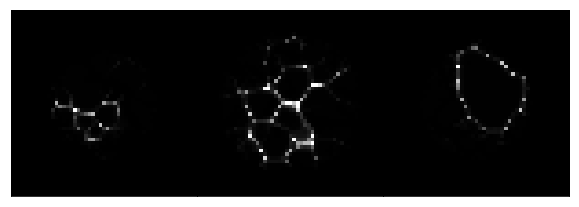

In [197]:
img, _ = hf.nii_load(out_img_path)
hf.draw_slices(img)

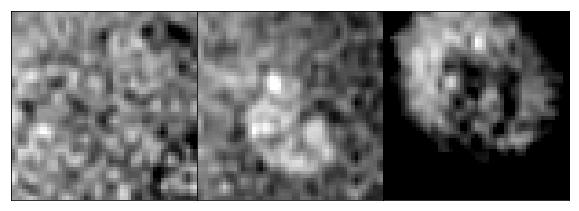

In [209]:
importlib.reload(hf)
img, _ = hf.nii_load(fixed_path)
hf.draw_slices(img, normalize=[600,1000])

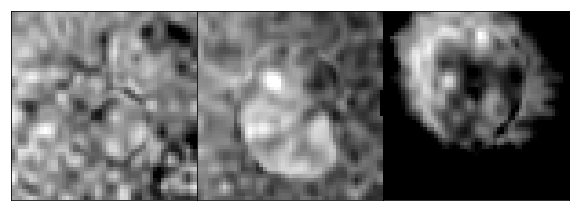

In [210]:
img, _ = hf.nii_load(moving_path)
hf.draw_slices(img, normalize=[600,1000])

In [276]:
importlib.reload(reg)
xform_path, crops, pads = reg.get_mask_Tx_shape(ct24_path, ct24_tumor_mask_path, mask_path=ball_mask_path)
img = reg.transform_region(ct24_path, xform_path, crops, pads, [1.]*3, ball_ct24_path)

xform_path, crops, pads = reg.get_mask_Tx_shape(mribl_art_path, mribl_tumor_mask_path)
_ = reg.transform_mask(mribl_enh_mask_path, mribl_art_path, xform_path,
                     crops, pads, [1.]*3, ball_mribl_enh_mask_path)

In [208]:
xform_path, crops, pads = reg.get_mask_Tx_shape(mribl_art_path, mribl_tumor_mask_path)
_ = reg.transform_mask(mribl_enh_mask_path, mribl_art_path, xform_path,
                     crops, pads, [1.]*3, ball_mribl_enh_mask_path)

In [270]:
fix_tmp_path="D:\\temp_fix.nii"
mov_tmp_path="D:\\temp_mov.nii"

img_m, img_m_dims = hf.nii_load(img_mov_path)
mask_m, mask_m_dims = masks.get_mask(mask_mov_path, img_m_dims, img_m.shape)

mask_m, crops_m = hf.crop_nonzero(mask_m)
img_m, _ = hf.crop_nonzero(img_m, crops_m)
img_m[mask_m == 0] = 0

R = 1.
mask_m_iso, _ = tr.rescale_img(mask_m, [R]*3, mask_m_dims)

mask_f = ball(max(mask_m_iso.shape)//2)
mask_f_iso = np.pad(mask_f, (np.ones((3,2))*5).astype(int), 'constant')
mask_m_iso, pads_m = hf.zeropad(mask_m_iso, mask_f_iso.shape, ignore_neg=True)

In [271]:
mask_m_iso.max()

255.0

In [233]:
mask_m_iso=((mask_m_iso>mask_m_iso.max()/2)*255).astype('uint8')

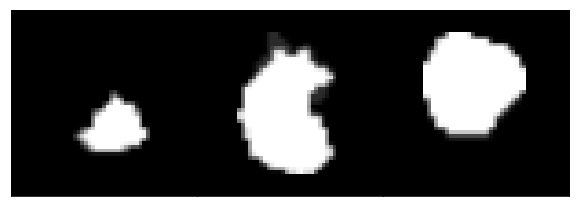

In [272]:
hf.draw_slices(mask_m_iso)

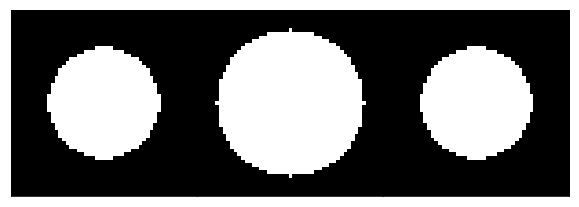

In [235]:
hf.draw_slices(mask_f_iso)

In [258]:
hf.save_nii(mask_f_iso*255, fix_tmp_path, [R]*3)
hf.save_nii(mask_m_iso, mov_tmp_path, [R]*3)

In [237]:
out_img_path="D:\\temp.nii"

In [273]:
importlib.reload(reg)
reg.reg_aligned_masks(mov_tmp_path, fix_tmp_path, out_img_path=out_img_path)

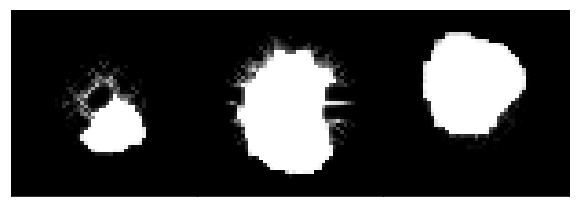

In [274]:
out_img,dims = hf.nii_load(out_img_path)
hf.draw_slices(out_img)

### Compose with rotation

In [191]:
mribl_liver_mask_path = join(target_dir, patient_id, "liver bl final.ids")
ct24_liver_mask_path = glob.glob(join(target_dir, patient_id, "wholeliver_24hCT*.ids"))[0]

In [ ]:
mribl_ct24_xform, ct24_tumor, mribl_tumor, mribl_ct24_crops = full_reg_masks(ct24_tumor_mask_path, ct24_path, mribl_tumor_mask_path, mribl_art_path)

In [ ]:
# BL MRI to 24h CT
vec_field = lm.reg_masks(ct_tumor_mask_path, blmri_tumor_mask_path)

In [ ]:
mribl_enh_mask = reg.apply_field(vec_field)

In [ ]:
ct24_lip = lm.seg_lipiodol()

In [ ]:
reg.reg_sitk(ct24_lip, vec_field)

In [114]:
mri_dcm_paths = [x for x in glob.glob(join(target_dir, '*', 'MRI-BL', '*20s*')) if '.nii' not in x]
mri_dcm_paths

In [ ]:
path_dict = {}
patient_id = '04'
for path in glob.glob(join(target_dir, patient_id, "MRI-BL","*","*")):
    header = hf.dcm_load_header(path)
    if len(header) > 0:
        series_descript = header[0][('0008', '103e')].value
        path_dict[path] = series_descript
        series_descript = series_descript.replace("/","-")
        os.rename(path, join(target_dir,patient_id, "MRI-BL", series_descript))

In [499]:
for path in glob.glob(join(target_dir, "*", "masks","*final*")):
    if not exists(path.replace(" final", "")):
        os.rename(path, path.replace(" final", ""))

for path in glob.glob(join(target_dir, "*")):
    os.makedirs(join(path, "masks"))

for path in glob.glob(join(target_dir, "*", "*.off")):
    os.rename(path, join(dirname(path), "masks", basename(path)))

### Bias field corr

In [122]:
mri_raw_paths = glob.glob(join(target_dir, '*', 'MRI-BL', 't1-art.nii.gz'))
mri_bfc_paths = [join(dirname(x), "t1-art-bfc.nii.gz") for x in mri_raw_paths]

In [176]:
importlib.reload(masks)

<module 'niftiutils.masks' from 'c:\\users\\clinton\\documents\\niftiutils\\niftiutils\\masks.py'>

In [ ]:
glob.glob(join(target_dir, patient_id, ''

In [ ]:
masks.mask2nii()

In [128]:
inputImage = sitk.ReadImage(mri_raw_paths[0])
maskImage = sitk.OtsuThreshold( inputImage, 0, 1, 200 )

if len ( sys.argv ) > 3:
    inputImage = sitk.Shrink( inputImage, [ int(sys.argv[3]) ] * inputImage.GetDimension() )
    maskImage = sitk.Shrink( maskImage, [ int(sys.argv[3]) ] * inputImage.GetDimension() )

inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )

corrector = sitk.N4BiasFieldCorrectionImageFilter()

numberFilltingLevels = 4
#corrector.SetMaximumNumberOfIterations( [ int( sys.argv[5] ) ] *numberFilltingLevels  )

output = corrector.Execute( inputImage, maskImage )

sitk.WriteImage( output, mri_bfc_paths[0] )

### Masks

## Lipiodol seg

In [82]:
importlib.reload(lm)

<module 'niftiutils.masks' from 'c:\\users\\clinton\\documents\\niftiutils\\niftiutils\\masks.py'>

In [144]:
# Lipiodol 3 masks
info = {}
for seg in glob.glob(join(mask_dir, "wholeliver_24hCT*.ids")):
    if dirname(seg) in info.keys():
        (ct_img, ct_dims, mask) = info[dirname(seg)]
    else:
        ct_img, ct_dims = hf.dcm_load(join(target_dir, patient_id, "CT24h"), True, True)
        mask, _ = masks.get_mask(seg, ct_dims, ct_img.shape)
        
    lm.seg_lipiodol((mask > 0) * ct_img, dirname(seg), ct_dims)
    info[dirname(seg)] = (ct_img, ct_dims, mask)
    break

In [ ]:
# Lipiodol target vs non-target masks
info = {}
for seg in glob.glob(join(target_dir,"*","wholeliver_24hCT*.ids")):
    if dirname(seg) in info.keys():
        (ct_img, ct_dims, mask) = info[dirname(seg)]
    else:
        ct_img, ct_dims = hf.dcm_load(join(dirname(seg), "CT24h"), True, True)
        mask, _ = masks.get_mask(seg, ct_dims, ct_img.shape)
        
    lm.seg_target_lipiodol((mask > 0) * ct_img, dirname(seg), ct_dims)
    info[dirname(seg)] = (ct_img, ct_dims, mask)
    #break